# Example Notebook For Associating Experimental Signals With The Carbon Network
Prior to running this notebook, the CarbonNetwork graphml file must be present in the build folder

In [1]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import networkx as nx
import os
import glob

from typing import List, Tuple

from tqdm.notebook import tqdm

# replace with submodules
# import sys
# sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
# from metatlas.io import feature_tools as ft
# sys.path.insert(0,'/global/homes/b/bpb/repos/blink')
# import blink

import analysis_tools as at

INFO:rdkit:Enabling RDKit 2023.09.1 jupyter extensions


In [3]:
# from metatlas.untargeted.tools import get_google_sheet
# file_df = get_google_sheet(notebook_name='Supplementary Tables',sheet_name='environmental')
# if not 'h5' in file_df.columns:
#     file_df['h5'] = file_df['parquet'].str.replace('.parquet','.h5')
# cols = ['parquet','h5']
# file_df = file_df[cols]

# # check if parquet files exist
# file_df['parquet_exists'] = file_df['parquet'].apply(os.path.exists)
# file_df['h5_exists'] = file_df['h5'].apply(os.path.exists)

# file_df = file_df[~file_df['h5_exists']]

# # old_path = '/global/cfs/cdirs/metatlas/raw_data/egsb/20240409_EB_NB_107915-001_PRISM-RtExu_combined-rep1-5_EXP120A_C18-EP_USDAY72349'
# # # see if the h5 files are in the old path
# file_df['old_h5'] = file_df['parquet'].apply(lambda x: x.replace('.parquet','.h5').replace('/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data','/pscratch/sd/b/bpb'))

# file_df['h5_old_exists'] = file_df['old_h5'].apply(os.path.exists)
# file_df = file_df[file_df['h5_old_exists']]
# print(file_df.shape)
# out = []
# for i,row in file_df.iterrows():
#     source_file = row['old_h5']
#     dest_file = row['parquet'].replace('.parquet','.h5')
#     print('Copying %s to %s'%(source_file,dest_file))
#     os.system('cp "%s" "%s"'%(source_file,dest_file))
#     out.append(dest_file)
# # file_df = file_df[file_df['parquet_exists'] & ~file_df['h5_exists'] & file_df['h5_old_exists']]
# # file_df['old_h5'].to_csv('missing_h5.csv',index=False)
# with open('missing.csv','w') as fid:
#     fid.write('\n'.join(out))

## Parameters
The next code block sets parameters that are used throughout the remainder of the notebook.

In [2]:
# experiment directory
## note: must follow Northen Lab file naming conventions and be converted to hdf5 format
# exp_dir  = ['/global/cfs/cdirs/metatlas/raw_data/egsb/20240409_EB_NB_107915-001_PRISM-RtExu_combined-rep1-5_EXP120A_C18-EP_USDAY72349']
# exp_dir = ['/global/cfs/cdirs/metatlas/raw_data/egsb/20231113_EB_SMK_107002-011_CenturyExp_20230414_EXP120A_C18-EP_USDAY72349',
        #    '/global/cfs/cdirs/metatlas/raw_data/jgi/20240112_JGI_MdR_109570-002_OMTSoil50g_Pilot_QEHF_C18_USDAY86082_CORRECTED']
# experiment directory
## note: must follow Northen Lab file naming conventions and be converted to hdf5 format
# files = glob.glob(exp_dir[0] + '/*NEG*.h5')
# files = [f for f in files if 'qc' not in f.lower()]
# files = [f for f in files if 'blank' not in f.lower()]
# print(len(files))
# tolerance in ppm between experimental signal and node mz
mz_ppm_tolerance = 5
peak_height_min = 1e4
num_datapoints_min = 10
# minimum MSMS score 
msms_score_min = 0.5

# minimum MSMS matching ion count
msms_matches_min = 3

# retention time range in minutes for feature finding
rt_range = [1, 700]

# tolerance in daltons used for calculating MS/MS similarity scores
frag_mz_tolerance = 0.05

In [5]:
from importlib import reload
at = reload(at)

In [3]:
from metatlas.untargeted.tools import get_google_sheet
file_df = get_google_sheet(notebook_name='Supplementary Tables',sheet_name='Table 1a')
if not 'h5' in file_df.columns:
    file_df['h5'] = file_df['parquet'].str.replace('.parquet','.h5')
cols = ['parquet','h5','environmental_subclass']
file_df = file_df[cols]
envo_name = get_google_sheet(notebook_name='Supplementary Tables',sheet_name='Table 1b')
file_df = pd.merge(file_df,envo_name[['name','id','common parent name']],left_on='environmental_subclass',right_on='id',how='inner')
# file_df = file_df[~file_df['h5'].str.contains('Frtlzr')]
file_df.shape

(1401, 6)

In [4]:
# get num mdm spectra in a parquet file
def get_num_mdm_spectra(parquet_file):
    df = pd.read_parquet(parquet_file)
    return df.shape[0]

# get num spectra in an h5 file
def get_num_spectra(h5_file):
    df = pd.read_hdf(h5_file,'ms2_neg')
    return df['rt'].nunique()

# use multiprocessing pool to get num mdm spectra
from multiprocessing import Pool
with Pool(20) as pool:
    file_df['num_mdm_spectra']  = pool.map(get_num_mdm_spectra,file_df['parquet'])

with Pool(20) as pool:
    file_df['num_spectra']  = pool.map(get_num_spectra,file_df['h5'])


In [5]:
file_df.shape

(1401, 8)

In [6]:
file_df.groupby('common parent name')['h5'].count()

common parent name
IHSS Reference Standards     27
fresh water                 221
sea water                   710
soil                        443
Name: h5, dtype: int64

In [7]:
print(file_df['num_spectra'].sum())
file_df.groupby('common parent name')['num_spectra'].sum()

5594721


common parent name
IHSS Reference Standards      94100
fresh water                  802481
sea water                   3159716
soil                        1538424
Name: num_spectra, dtype: int64

In [8]:
print(file_df['num_mdm_spectra'].sum())
file_df.groupby('common parent name')['num_mdm_spectra'].sum()

693383


common parent name
IHSS Reference Standards      5293
fresh water                 104972
sea water                   454024
soil                        129094
Name: num_mdm_spectra, dtype: int64

In [10]:
file_df.groupby('name')['num_mdm_spectra'].sum()

name
IHSS Reference Standards      5293
agricultural soil             2233
coastal sea water           454024
desert sand                  50699
fresh water                  15179
groundwater                   1058
humic lake                    9710
leachate                     10832
peat soil                    24320
permafrost                   15562
river water                  68121
stream sediment                 72
tropical forest soil         17712
vegetable garden soil        18568
Name: num_mdm_spectra, dtype: int64

In [10]:
# df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/public_and_internal_files_with_massive_and_redu.tsv', sep='\t')
# df = df[df['SampleType']=='plant']
# df = df[~df['buddy'].str.contains('qc',case=False)]
# df = df[~df['buddy'].str.contains('blank',case=False)]
# out_dir = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data'
# temp_files = df['h5'].tolist()
# files = []
# for f in temp_files:
#     base_dir = os.path.dirname(f)
#     base_name = os.path.basename(f)
#     new_dir = os.path.join(out_dir,base_dir)
#     new_name = os.path.join(new_dir,base_name)
#     files.append(new_name)
#     if not os.path.isfile(new_name):
#         print('File Not Found!')
#         print(new_name)
#         print(f)
# files_data = pd.DataFrame(files,columns=['filename'])
# files = files_data['filename'].tolist()


In [12]:
# collect and merge required data and metadata
from importlib import reload
at = reload(at)

node_data = at.graph_to_df()
print(node_data.shape)
node_atlas = at.make_node_atlas(node_data, rt_range)
merged_node_data = at.merge_spectral_data(node_data)
print(merged_node_data.shape)
# files_data = at.get_files_df(exp_dir)
# files = files_data['filename'].tolist()

INFO:root:Processing envnet_original_spectra.mgf


(14340, 86)


INFO:root:Processing envnet_mdm_spectra.mgf


(14340, 104)


In [13]:
sum(pd.notna(node_data['inchi_key_identity'])),node_data['inchi_key_identity'].nunique()

(782, 692)

In [ ]:
# get ms1 and ms2 data
files = file_df['h5'].tolist()
ms1_data = at.get_sample_ms1_data(node_atlas, files, mz_ppm_tolerance,peak_height_min,num_datapoints_min)
max_ms1_data = at.get_best_ms1_rawdata(ms1_data,node_data)
ms1_data.to_csv('../../data/Environments_ms1_data_0p1.csv')


# shuffle files
# np.random.shuffle(files)
# files = files[:100]
files = file_df['parquet'].tolist()
ms2_data = at.get_sample_ms2_data(files,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance,frag_mz_tolerance)
ms2_data = pd.concat([d for d in ms2_data if d is not None])
ms2_data.to_csv('../../data/Environments_ms2_data_0p1.csv')
max_ms2_data = at.get_best_ms2_rawdata(ms2_data)
# best_hits = at.get_best_ms1_ms2_combined(max_ms1_data,max_ms2_data)



In [24]:
ms1_data = pd.read_csv('../../data/Environments_ms1_data_0p1.csv')
ms1_data['lcmsrun_observed'] = ms1_data['lcmsrun_observed'].str.replace('.h5','')
ms1_data['lcmsrun_observed'] = ms1_data['lcmsrun_observed'].str.replace('/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/','')
ms1_data.head()

,Unnamed: 0,node_id,num_datapoints,peak_area,peak_height,mz_centroid,rt_peak,lcmsrun_observed
0,0,10023.0,21.0,1.280820e+05,11372.152344,385.068230,12.276840,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...
1,1,10113.0,1056.0,3.189547e+06,20833.683594,386.840700,34.659367,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...
2,2,10114.0,22.0,2.554322e+05,27305.619141,386.939005,1.192180,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...
3,3,10149.0,24.0,5.186842e+05,83531.117188,387.119373,12.189328,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...
4,4,1031.0,842.0,1.671135e+06,10757.001953,189.931326,34.627178,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...


In [25]:
ms1_data.shape

(13465334, 8)

In [26]:
ms2_data = pd.read_csv('../../data/Environments_ms2_data_0p1.csv')
ms2_data['lcmsrun_observed'] = ms2_data['lcmsrun_observed'].str.replace('.parquet','')
ms2_data['lcmsrun_observed'] = ms2_data['lcmsrun_observed'].str.replace('/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/','')
ms2_data.head()

,Unnamed: 0,query,ref,score,matches,best_match_method,node_id,lcmsrun_observed
0,0,0,4230,1.000000,3.0,score_mdm,3547.0,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...
1,1,1,4231,1.000000,4.0,score_mdm,3548.0,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...
2,0,2,3177,0.773141,3.0,score_mdm,6105.0,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...
3,0,0,9176,1.000000,3.0,score_mdm,7965.0,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...
4,1,1,2098,0.821894,69.0,score_or,1766.0,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...


In [27]:
ms1_data.loc[0,'lcmsrun_observed']

'massive/v01/MSV000081030/ccms_peak/raw/MTBLS144/Mtab_FT_012611_09'

In [28]:
ms2_data.loc[0,'lcmsrun_observed']

'massive/v01/MSV000081030/ccms_peak/raw/MTBLS144/Mtab_FT_012611_07'

In [30]:
# keep ms1_data rows where node_id and lcmsrun_observed are in the ms2_data
idx1 = ms1_data['node_id'].isin(ms2_data['node_id'])
idx2 = ms1_data['lcmsrun_observed'].isin(ms2_data['lcmsrun_observed'])
ms1_data = ms1_data[idx1 & idx2]
ms1_data.shape,sum(idx1),sum(idx2),sum(idx1 & idx2)

((13454036, 8), 13465323, 13454047, 13454036)

In [32]:
file_df['lcmsrun_observed'] = file_df['h5'].str.replace('.h5','')
file_df['lcmsrun_observed'] = file_df['lcmsrun_observed'].str.replace('/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/','')

In [34]:
ms1_data = pd.merge(ms1_data,file_df,on='lcmsrun_observed')
ms1_data.rename(columns={'common parent name':'environment'},inplace=True)
ms1_data.rename(columns={'name':'specific_environment'},inplace=True)
ms1_data.head()


,Unnamed: 0,node_id,num_datapoints,peak_area,peak_height,mz_centroid,rt_peak,lcmsrun_observed,parquet,h5,environmental_subclass,specific_environment,id,environment,num_mdm_spectra,num_spectra
0,408,1000.0,975.0,2.113048e+06,10752.345703,188.932914,34.630669,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water,7,3672
1,409,10023.0,18.0,1.080409e+05,12065.768555,385.068121,12.307693,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water,7,3672
2,410,10074.0,11.0,9.189418e+04,20437.746094,385.165271,23.856382,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water,7,3672
3,411,10075.0,11.0,9.189418e+04,20437.746094,385.165271,23.856382,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water,7,3672
4,412,10076.0,12.0,9.270496e+04,20437.746094,385.165257,23.856382,massive/v01/MSV000081030/ccms_peak/raw/MTBLS14...,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water,7,3672


12224.3564453125


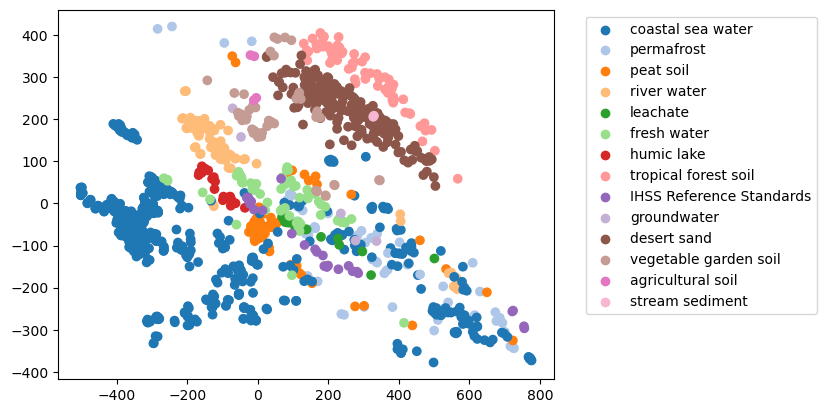

In [37]:
p = pd.pivot_table(ms1_data,values='peak_area',index=['lcmsrun_observed','environment','specific_environment'],columns='node_id')
temp = p.values
min_value = np.nanmin(temp)
print(min_value)
p.fillna(min_value*2/3,inplace=True)
# make a PCA plot of the MS1 data and color by environment
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# idx = pd.notna(ms1_data['class_results_propagated'])
# p = pd.pivot_table(ms1_data[idx],values='peak_area',columns='class_results_propagated',index=['lcmsrun_observed','environmental_subclass','name','id','environment'],aggfunc='sum',fill_value=0)
# p.head()
X = p.values
X = np.log2(X+1)
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X)

X_pca = pca.transform(X)

my_environments = p.index.get_level_values('specific_environment')
unique_environments = my_environments.unique()
colors = dict(zip(unique_environments, plt.cm.tab20.colors[:len(unique_environments)]))
color_values = my_environments.map(colors)

# also shuffle through three marker styles
# markers = ['o','s','^']
# markers = np.tile(markers,len(unique_environments)//len(markers)+1)[:len(unique_environments)]
# marker_values = my_environments.map(dict(zip(unique_environments,markers)))

fig,ax = plt.subplots()
ax.scatter(X_pca[:,0],X_pca[:,1],c=color_values)#,marker=marker_values)

for environment in unique_environments:
    ax.scatter([],[],label=environment,color=colors[environment])#,marker=markers[unique_environments.get_loc(environment)])

# move legend outside of plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:

ms2_data = pd.merge(ms2_data,file_df,left_on='lcmsrun_observed',right_on='parquet',how='inner')

# use the more granular environment name
# ms2_data.rename(columns={'name':'environment'},inplace=True)
# use the broader environment name
ms2_data.rename(columns={'common parent name':'environment'},inplace=True)
ms2_data.head()

,Unnamed: 0,query,ref,score,matches,best_match_method,node_id,lcmsrun_observed,parquet,h5,environmental_subclass,name,id,environment
0,0,0,4230,1.000000,3.0,score_mdm,3547.0,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water
1,1,1,4231,1.000000,4.0,score_mdm,3548.0,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water
2,0,2,3177,0.773141,3.0,score_mdm,6105.0,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water
3,0,0,9176,1.000000,3.0,score_mdm,7965.0,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water
4,1,1,2098,0.821894,69.0,score_or,1766.0,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water


In [9]:
# in environment, replace "Reference" with "Ref."
ms2_data['environment'] = ms2_data['environment'].str.replace('Reference','Ref.')
ms2_data['environment'].value_counts()

sea water              1745468
fresh water             318777
soil                    308964
IHSS Ref. Standards      16858
Name: environment, dtype: int64

In [15]:
commonality = ms2_data.groupby('node_id')['environment'].value_counts().reset_index(name='count')
commonality = commonality.pivot(index='node_id',columns='environment',values='count').fillna(0)
commonality = commonality>0
cols = commonality.columns
commonality['commonality'] = commonality.sum(axis=1)
commonality.drop(columns=cols,inplace=True)
commonality.reset_index(inplace=True)
commonality['node_id'] = commonality['node_id'].astype(str)
commonality

environment,node_id,commonality
0,5.0,1
1,9.0,2
2,11.0,2
3,12.0,2
4,13.0,1
...,...,...
15917,16366.0,1
15918,16367.0,1
15919,16368.0,1
15920,16369.0,1


In [16]:
G = nx.read_graphml('../../data/envnet.graphml')
# great a new attribuyte called "high_quaternary" and set it to False
nx.set_node_attributes(G, "commonality", 0)
commonality = commonality[commonality['node_id'].isin(list(G.nodes()))]
# label the neighbors of the nodes we want with a new attribute called "high_quaternary" and set it to True
# use an egograph to get the neighbors of the nodes we want
for i,row in commonality.iterrows():
    G.nodes[row['node_id']]['commonality'] = row['commonality']

# export the graph
nx.write_graphml(G, '../../data/envnet.graphml')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='commonality', ylabel='degree'>

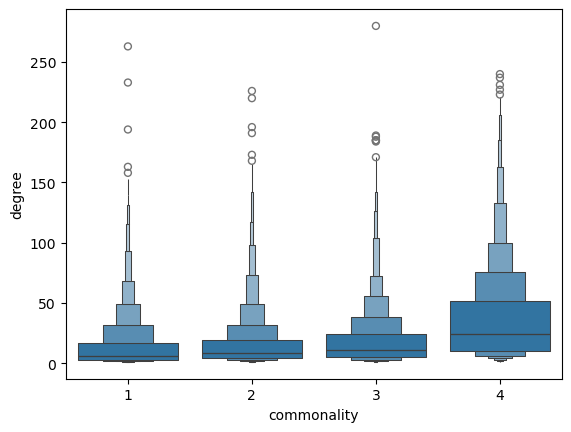

In [17]:
# for each level of commonality, histogram the node degree
# Get commonality for each node
commonality = nx.get_node_attributes(G,'commonality')

# Get degree for each node
degree = dict(G.degree())

# Make a dataframe
df = pd.DataFrame(list(degree.items()),columns=['node_id','degree'])
df['commonality'] = df['node_id'].map(commonality)
fig,ax = plt.subplots()
# make a seaborn boxen plot of degree by commonality
import seaborn as sns
sns.boxenplot(data=df,x='commonality',y='degree',ax=ax)

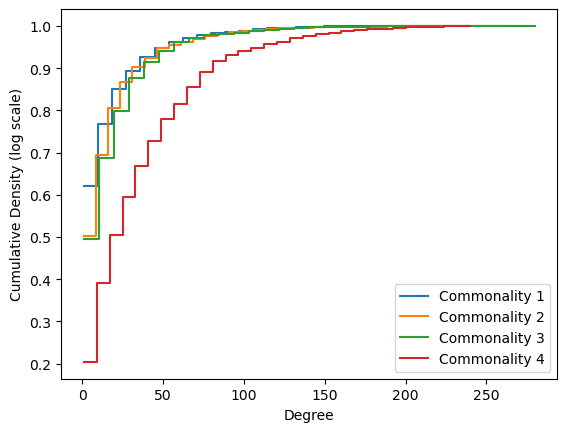

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx

# Assuming G is your graph and commonality is already calculated
# Get commonality for each node
commonality = nx.get_node_attributes(G, 'commonality')

# Get degree for each node
degree = dict(G.degree())

# Make a dataframe
df = pd.DataFrame(list(degree.items()), columns=['node_id', 'degree'])
df['commonality'] = df['node_id'].map(commonality)

# Create a cumulative distribution plot
fig, ax = plt.subplots()
for common_level in [1,2,3,4]:
    subset = df[df['commonality'] == common_level]
    sns.histplot(subset['degree'], bins=30, cumulative=True, stat='density', element='step', fill=False, ax=ax, label=f'Commonality {common_level}')
# ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('Cumulative Density (log scale)')
ax.legend()
plt.show()

<Axes: xlabel='log_degree', ylabel='Density'>

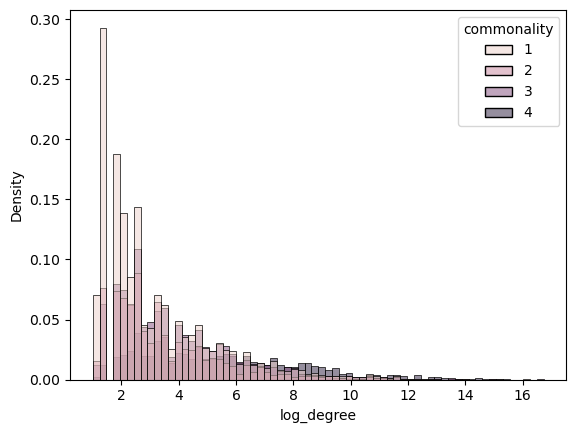

In [19]:
df['log_degree'] = df['degree'].apply(lambda x: x**0.5)
fig, ax = plt.subplots()
sns.histplot(data=df, hue='commonality', x='log_degree', ax=ax,stat='density')

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

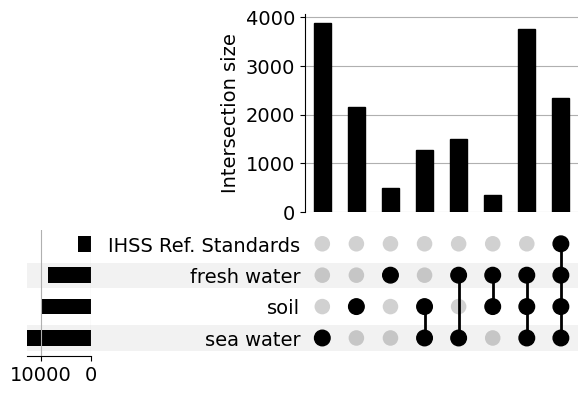

In [21]:
# make an upset plot
# from upsetplot import generate_counts
# from upsetplot import plot
# from upsetplot import from_memberships
from upsetplot import UpSet
# from upsetplot import plot_matrix
unique_nodes = ms2_data.groupby('environment')['node_id'].value_counts().reset_index(name='count')
unique_nodes = unique_nodes[unique_nodes['count']>0]
unique_nodes = unique_nodes.groupby('environment')['node_id'].unique()
unique_nodes = unique_nodes.to_dict()

import pandas as pd

# Convert the dictionary to a list of tuples
data = [(env, node) for env, nodes in unique_nodes.items() for node in nodes]

# Create a DataFrame from the list of tuples
# Create a DataFrame from the list of tuples
df = pd.DataFrame(data, columns=['Environment', 'Node'])

# Pivot the DataFrame to get the desired format
df = df.groupby('Node')['Environment'].apply(lambda x: pd.Series(1, x)).unstack().fillna(0)

# Convert the DataFrame to boolean
df = df.astype(bool)

cols = df.columns.tolist()
# Group by the columns and count the number of True values
g = df.groupby(cols).size()

# Set Matplotlib parameters to increase font sizes
plt.rcParams.update({
    'font.size': 14,        # Base font size
    'axes.titlesize': 16,   # Title font size
    'axes.labelsize': 14,   # Axis label font size
    'xtick.labelsize': 14,  # X-tick label font size
    'ytick.labelsize': 14,  # Y-tick label font size
    'legend.fontsize': 14,  # Legend font size
    'figure.titlesize': 18  # Figure title font size
})

# Reset the index and rename the count column
# df = df.reset_index().rename(columns={0: 'count'})
upset = UpSet(g,min_degree=0,max_degree=4,min_subset_size=50)
upset.plot()


In [20]:
g.to_csv('../../data/Environments_upset_data_0p1.csv')

In [ ]:
# from the slope of the saturation curve, we can assume that the number of unique features is 10% of the total number of features.
# that means the other 90% are redundant features and shared between samples
# this is a rough estimate and should be refined

# using a gaussian model, for a given number of samples

# select two random samples
# calculate the number of unique features
# calculate the number of shared features




import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor

# Assuming ms2_data is defined somewhere above this code snippet
# and samples is a list or array-like object containing your samples

def get_shared_and_unique_features(args):
    ms2_data, sample1, sample2 = args
    sample1_data = ms2_data[ms2_data['lcmsrun_observed'] == sample1]
    sample2_data = ms2_data[ms2_data['lcmsrun_observed'] == sample2]

    sample1_features = sample1_data['node_id'].unique()
    sample2_features = sample2_data['node_id'].unique()

    num_shared = len(set(sample1_features).intersection(set(sample2_features)))
    num_total = len(set(sample1_features).union(set(sample2_features)))
    num_unique = num_total - num_shared
    return {'shared': num_shared, 'unique': num_unique, 'total': num_total}

# Prepare arguments for each trial
num_trials = 10
samples = ms2_data['lcmsrun_observed'].unique()
trial_args = [(ms2_data, np.random.choice(samples), np.random.choice(samples)) for _ in range(num_trials)]

# Execute in parallel
with ProcessPoolExecutor() as executor:
    results = list(executor.map(get_shared_and_unique_features, trial_args))

shared_among_pairs = pd.DataFrame(results)
print(shared_among_pairs)

In [ ]:
cols = ['lcmsrun_observed', 'parquet', 'h5',
       'environmental_subclass', 'environment', 'id']
g = ms2_data.groupby(cols).size().reset_index().rename(columns={0:'count'}).sort_values('count',ascending=False).drop_duplicates('environment')
top_files = g['h5'].tolist()
with open('top_files.txt','w') as fid:
    fid.write('\n'.join(top_files))
top_files

In [22]:
temp_node_data = node_data[['node_id','high_quaternary','high_quaternary_propagated','class_results','class_results_propagated']].copy()
temp_node_data['high_quaternary_propagated'].value_counts()

Undefined                                        9907
Neighbors of zero quaternary Carbons             4053
Neighbors of three or more quaternary Carbons     380
Name: high_quaternary_propagated, dtype: int64

In [ ]:
num_envs_q

In [23]:
node_data['commonality'].value_counts().sort_index()

1    5557
2    2896
3    3618
4    2269
Name: commonality, dtype: int64

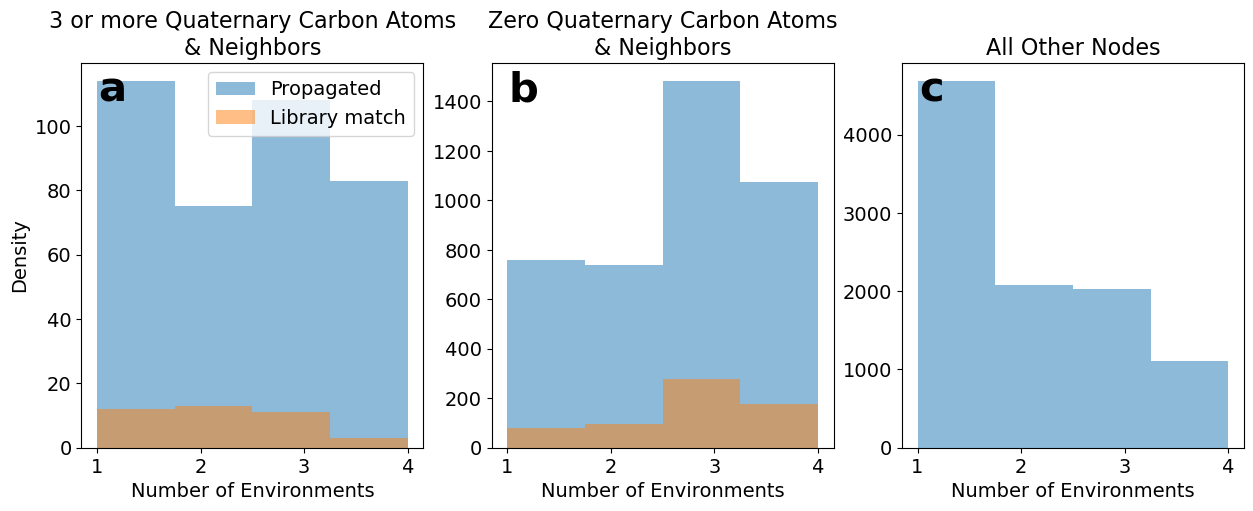

In [27]:
import seaborn as sns

ms2_data['temp'] = 1
temp_node_data = node_data[['node_id','high_quaternary','high_quaternary_propagated','class_results','class_results_propagated']].copy()
# temp_node_data['class_results'].fillna('Unclassified',inplace=True)
# temp_node_data['class_results_propagated'].fillna('Unclassified',inplace=True)
ms2_data['node_id'] = ms2_data['node_id'].astype(str)
# temp_node_data['class_results_propagated'] = temp_node_data['class_results_propagated'].apply(lambda x: 'Terpenoid' if 'terpenoid' in x.lower() else x)
temp = pd.merge(temp_node_data,ms2_data[['node_id','temp','environment']],on='node_id',how='left')

num_envs_q = pd.pivot_table(temp,index=['node_id','high_quaternary_propagated','high_quaternary'],columns=['environment'],values='temp',aggfunc='count')
num_envs_q.fillna(0,inplace=True)
num_envs_q[num_envs_q>0] = 1
num_envs_q = num_envs_q.astype(int)
num_envs_q['num_envs'] = num_envs_q.sum(axis=1)
num_envs_q.reset_index(inplace=True,drop=False)
num_envs_q
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
ax[0].hist(num_envs_q.loc[num_envs_q['high_quaternary_propagated']=='Neighbors of three or more quaternary Carbons','num_envs'],bins=4,alpha=0.5,label='Propagated',density=False)
ax[0].hist(num_envs_q.loc[num_envs_q['high_quaternary']=='Three or more quaternary Carbons','num_envs'],bins=4,alpha=0.5,label='Library match',density=False)
ax[1].hist(num_envs_q.loc[num_envs_q['high_quaternary_propagated']=='Neighbors of zero quaternary Carbons','num_envs'],bins=4,alpha=0.5,label='Low Quaternary Propagated',density=False)
ax[1].hist(num_envs_q.loc[num_envs_q['high_quaternary']=='Zero quaternary Carbons','num_envs'],bins=4,alpha=0.5,label='Low Quaternary',density=False)

ax[2].hist(num_envs_q.loc[num_envs_q['high_quaternary_propagated']=='Undefined','num_envs'],bins=4,alpha=0.5,label='Unclassified',density=False)
ax[0].set_title('3 or more Quaternary Carbon Atoms\n& Neighbors')
ax[1].set_title('Zero Quaternary Carbon Atoms\n& Neighbors')
ax[2].set_title('All Other Nodes')
ax[0].set_xlabel('Number of Environments')
ax[1].set_xlabel('Number of Environments')
ax[2].set_xlabel('Number of Environments')
ax[0].set_ylabel('Density')
ax[0].legend()
# ax[1].legend()


# add a,b,c labels to each subplot
import string
for i,axi in enumerate(ax):
    axi.text(0.05, 0.9, string.ascii_lowercase[i],
            transform=axi.transAxes, size=30, weight='bold')

In [10]:
ms2_data['temp'] = 1
temp_node_data = node_data[['node_id','class_results','class_results_propagated']].copy()
temp_node_data['class_results'].fillna('Unclassified',inplace=True)
temp_node_data['class_results_propagated'].fillna('Unclassified',inplace=True)
ms2_data['node_id'] = ms2_data['node_id'].astype(str)
# temp_node_data['class_results_propagated'] = temp_node_data['class_results_propagated'].apply(lambda x: 'Terpenoid' if 'terpenoid' in x.lower() else x)
temp = pd.merge(temp_node_data,ms2_data[['node_id','temp','environment']],on='node_id',how='left')
num_envs = pd.pivot_table(temp,index=['node_id','class_results','class_results_propagated'],columns=['environment'],values='temp',aggfunc='count')
num_envs.fillna(0,inplace=True)
num_envs[num_envs>0] = 1
num_envs = num_envs.astype(int)
num_envs['num_envs'] = num_envs.sum(axis=1)
num_envs.to_csv('../../data/num_environment_node_data.csv')
num_envs

,,environment,IHSS Ref. Standards,fresh water,sea water,soil,num_envs
node_id,class_results,class_results_propagated,,,,,
10000.0,Unclassified,Unclassified,0,0,0,1,1
10001.0,Unclassified,Unclassified,0,0,0,1,1
10002.0,Unclassified,Unclassified,0,0,0,1,1
10003.0,Unclassified,Unclassified,0,0,0,1,1
10006.0,Unclassified,Unclassified,0,0,1,0,1
...,...,...,...,...,...,...,...
9994.0,Unclassified,Unclassified,0,0,1,0,1
9995.0,Unclassified,Unclassified,0,0,1,0,1
9997.0,Unclassified,Unclassified,0,0,0,1,1


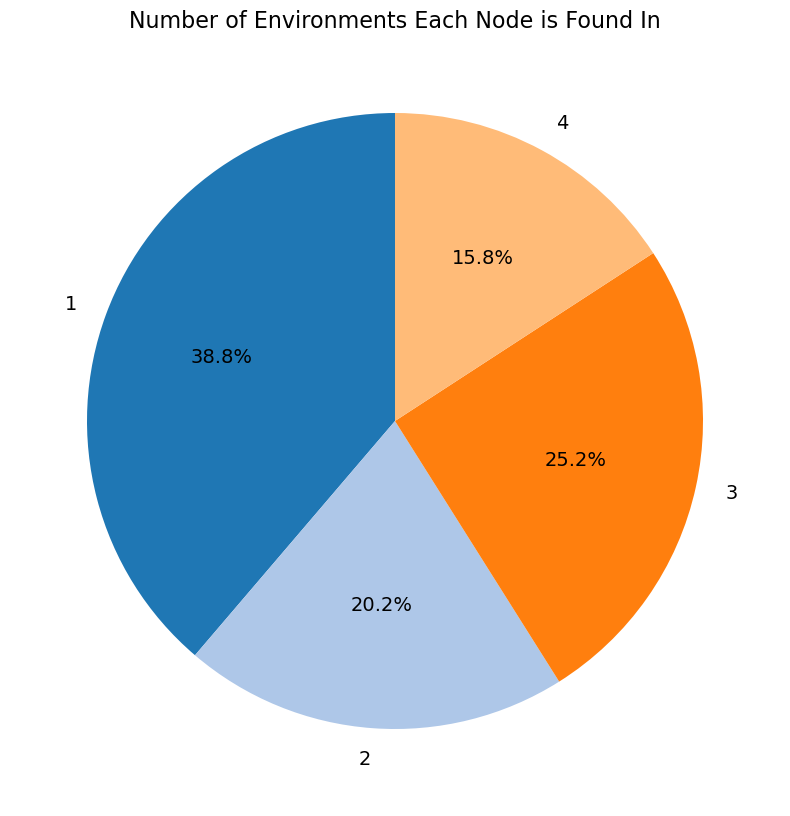

In [29]:
# make a pie chart of the number of environments each node is found in
def make_pie(num_envs):
    num_envs = num_envs[num_envs['num_envs']>0]
    num_envs = num_envs.groupby('num_envs').size().reset_index().rename(columns={0:'count'})
    num_envs['num_envs'] = num_envs['num_envs'].astype(str)
    # num_envs = num_envs.sort_values('num_envs')
    num_envs['num_envs'] = num_envs['num_envs'].astype(str)
    num_envs = num_envs.set_index('num_envs')

    # use a colormap with more colors
    colors = plt.cm.tab20.colors


    num_envs.plot.pie(y='count',figsize=(10,10),autopct='%1.1f%%',startangle=90,colors=colors)
    plt.ylabel('')
    plt.title('Number of Environments Each Node is Found In')
    # remove the legend
    plt.legend().remove()
    plt.savefig('num_environments_pie_chart.pdf',bbox_inches='tight')
    return num_envs

g = make_pie( num_envs)

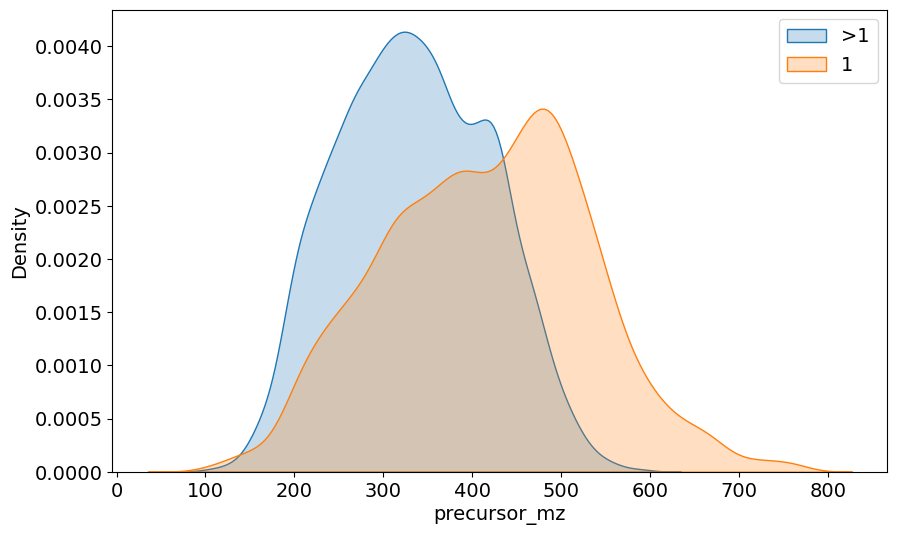

In [32]:
import seaborn as sns
g = num_envs.copy()
g.reset_index(inplace=True)
g = g[['node_id','num_envs']]
g = pd.merge(g,node_data[['node_id','precursor_mz']],on='node_id',how='left')
g = g[g['num_envs']>0]
g = g[g['precursor_mz']>0]
# as a function of num_envs plot the precursor_mz distribution
fig, ax = plt.subplots(1,1,figsize=(10,6))
# g.boxplot(column='precursor_mz',by='num_envs',ax=ax)
idx = g['num_envs']>=2
sns.kdeplot(g.loc[idx,'precursor_mz'],label='>1',shade=True)
idx = g['num_envs']<2
sns.kdeplot(g.loc[idx,'precursor_mz'],label='1',shade=True)
plt.legend()


In [ ]:

# highlight the lower and upper 10% of the confidence interval
# regression plot with confidence interval

# sns.regplot(x='num_envs',y='precursor_mz',data=g,ax=ax)
# plt.title('Precursor MZ vs Number of Environments')
# plt.savefig('precursor_mz_vs_num_envs.pdf',bbox_inches='tight')


# test if there is a significant difference in the precursor_mz distribution between nodes found in different numbers of environments
from scipy.stats import kruskal
import numpy as np
groups = []
for name,group in g.groupby('num_envs'):
    groups.append(group['precursor_mz'].values)
print(kruskal(*groups))

# test if there is a significant correlation between the number of environments a node is found in and the precursor_mz
from scipy.stats import spearmanr
print(spearmanr(g['num_envs'],g['precursor_mz']))


In [59]:
# g = num_envs[num_envs['num_envs']>0].copy()
# g = g.groupby('num_envs').size().reset_index().rename(columns={0:'count'})
# # also list the count of nodes in each environment for each frequency
# fig,ax = plt.subplots(ncols=1,nrows=15,figsize=(10,20),sharex=True,sharey=True)
# for i in range(15):
#     m = num_envs[num_envs['num_envs']==i+1].copy()
#     m = m.sum()
#     m = m.drop('num_envs')
#     # m = m.sort_values(ascending=False)
#     m.sort_index(inplace=True)
#     m.plot.bar(ax=ax[i])
#     ax[i].set_ylabel('%d Env.'%(i+1))


In [33]:
sum(node_data['class_results'].notnull()),sum(node_data['class_results_propagated'].notnull()),node_data.shape[0]

(664, 5466, 14340)

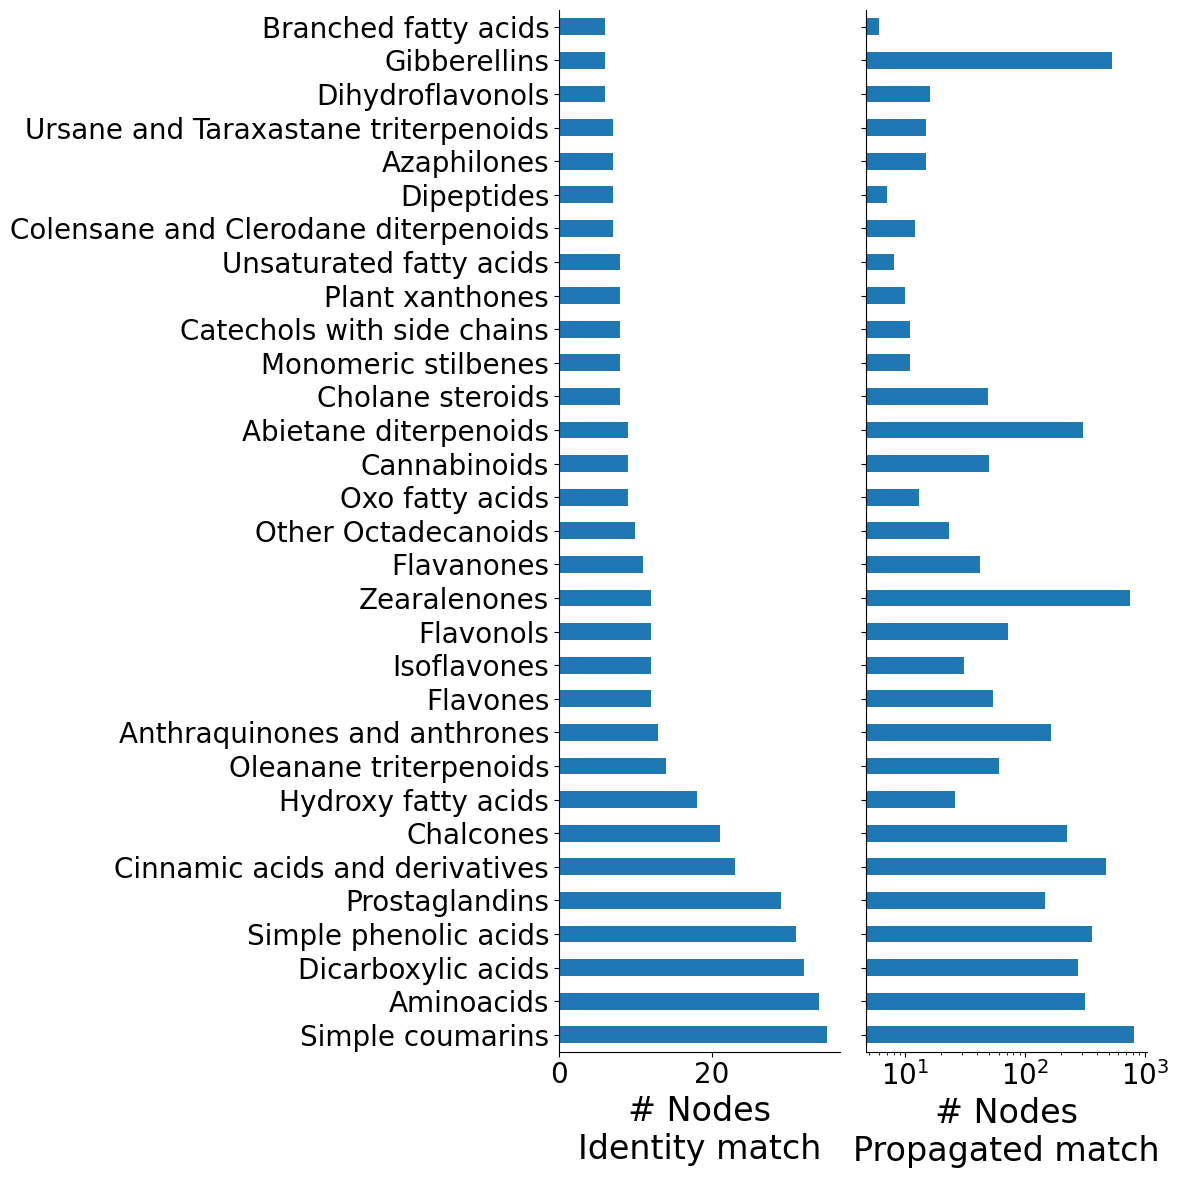

In [46]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,12),sharey=True)
g = node_data.groupby('class_results')['node_id'].count()
g = g[g>5].sort_values(ascending=False)
g.plot(kind='barh',ax=ax[0])
my_order = g.index.to_list()
g = node_data.groupby('class_results_propagated')['node_id'].count()
g = g[g>4].sort_values(ascending=False)
g = g.loc[my_order]
g.plot(kind='barh',ax=ax[1])
ax[1].set_xscale('log')
ax[0].set_ylabel('Compound Class',fontsize=24)
ax[0].set_xlabel('# Nodes\nIdentity match',fontsize=24)
ax[1].set_xlabel('# Nodes\nPropagated match',fontsize=24)
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=20)

# add a,b,c labels to each subplot, compensa5te for the shared y axis
# import string
# for i,axi in enumerate(ax):
#     axi.text(0.85, 0.96, string.ascii_lowercase[i], transform=axi.transAxes, size=30, weight='bold')

# remove the plot frame
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_ylabel('')

plt.tight_layout()

In [62]:
# g = ms2_data.groupby('class_results_propagated')['node_id'].apply(lambda x: len(x.nunique())).reset_index()
# g = g[g['count']>10]
# g.sort_values('mean',ascending=False,inplace=True)
# g.rename(columns={'mean':'specificity','count':'number of nodes'},inplace=True)
# g.to_csv('../../data/node_specificity_withcompoundclass.csv')

# fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,8),sharey=True)
# g['specificity'].plot(kind='barh',ax=ax[0])
# # offset the second bar plot by bar width
# # ax2.spines['top'].set_position(('outward', 0))
# # ax2.spines['top'].set_color('red')
# # ax2.spines['top'].set_linewidth(2)
# # ax2.set_xlim(ax.get_xlim())
# # ax2.set_xscale('log')

# # Get the current bar positions and widths
# # positions = ax.get_yticks()
# # width = ax.patches[0].get_width()

# # ax2.set_ylabel('')
# ax[0].set_xlabel('Fraction of nodes specific to an environment')
# ax[0].set_ylabel('Propagated compound class')
# ax[0].set_ylim(-1,len(g))
# ax[0].set_xlim(0,0.5)
# # Add the width to the positions for the second bar chart
# g['number of nodes'].plot(kind='barh',ax=ax[1])
# ax[1].set_xlabel('Number of nodes')
# ax[1].set_xscale('log')
# # add a legend for both axes locate it in the upper right corner
# # fig.legend(['Specificity','Number of Nodes'],bbox_to_anchor=(0.95,0.85), loc="upper right")
# plt.tight_layout()
# plt.show()
# fig.savefig('../../figures/node_specificity_withcompoundclass.pdf',bbox_inches='tight')


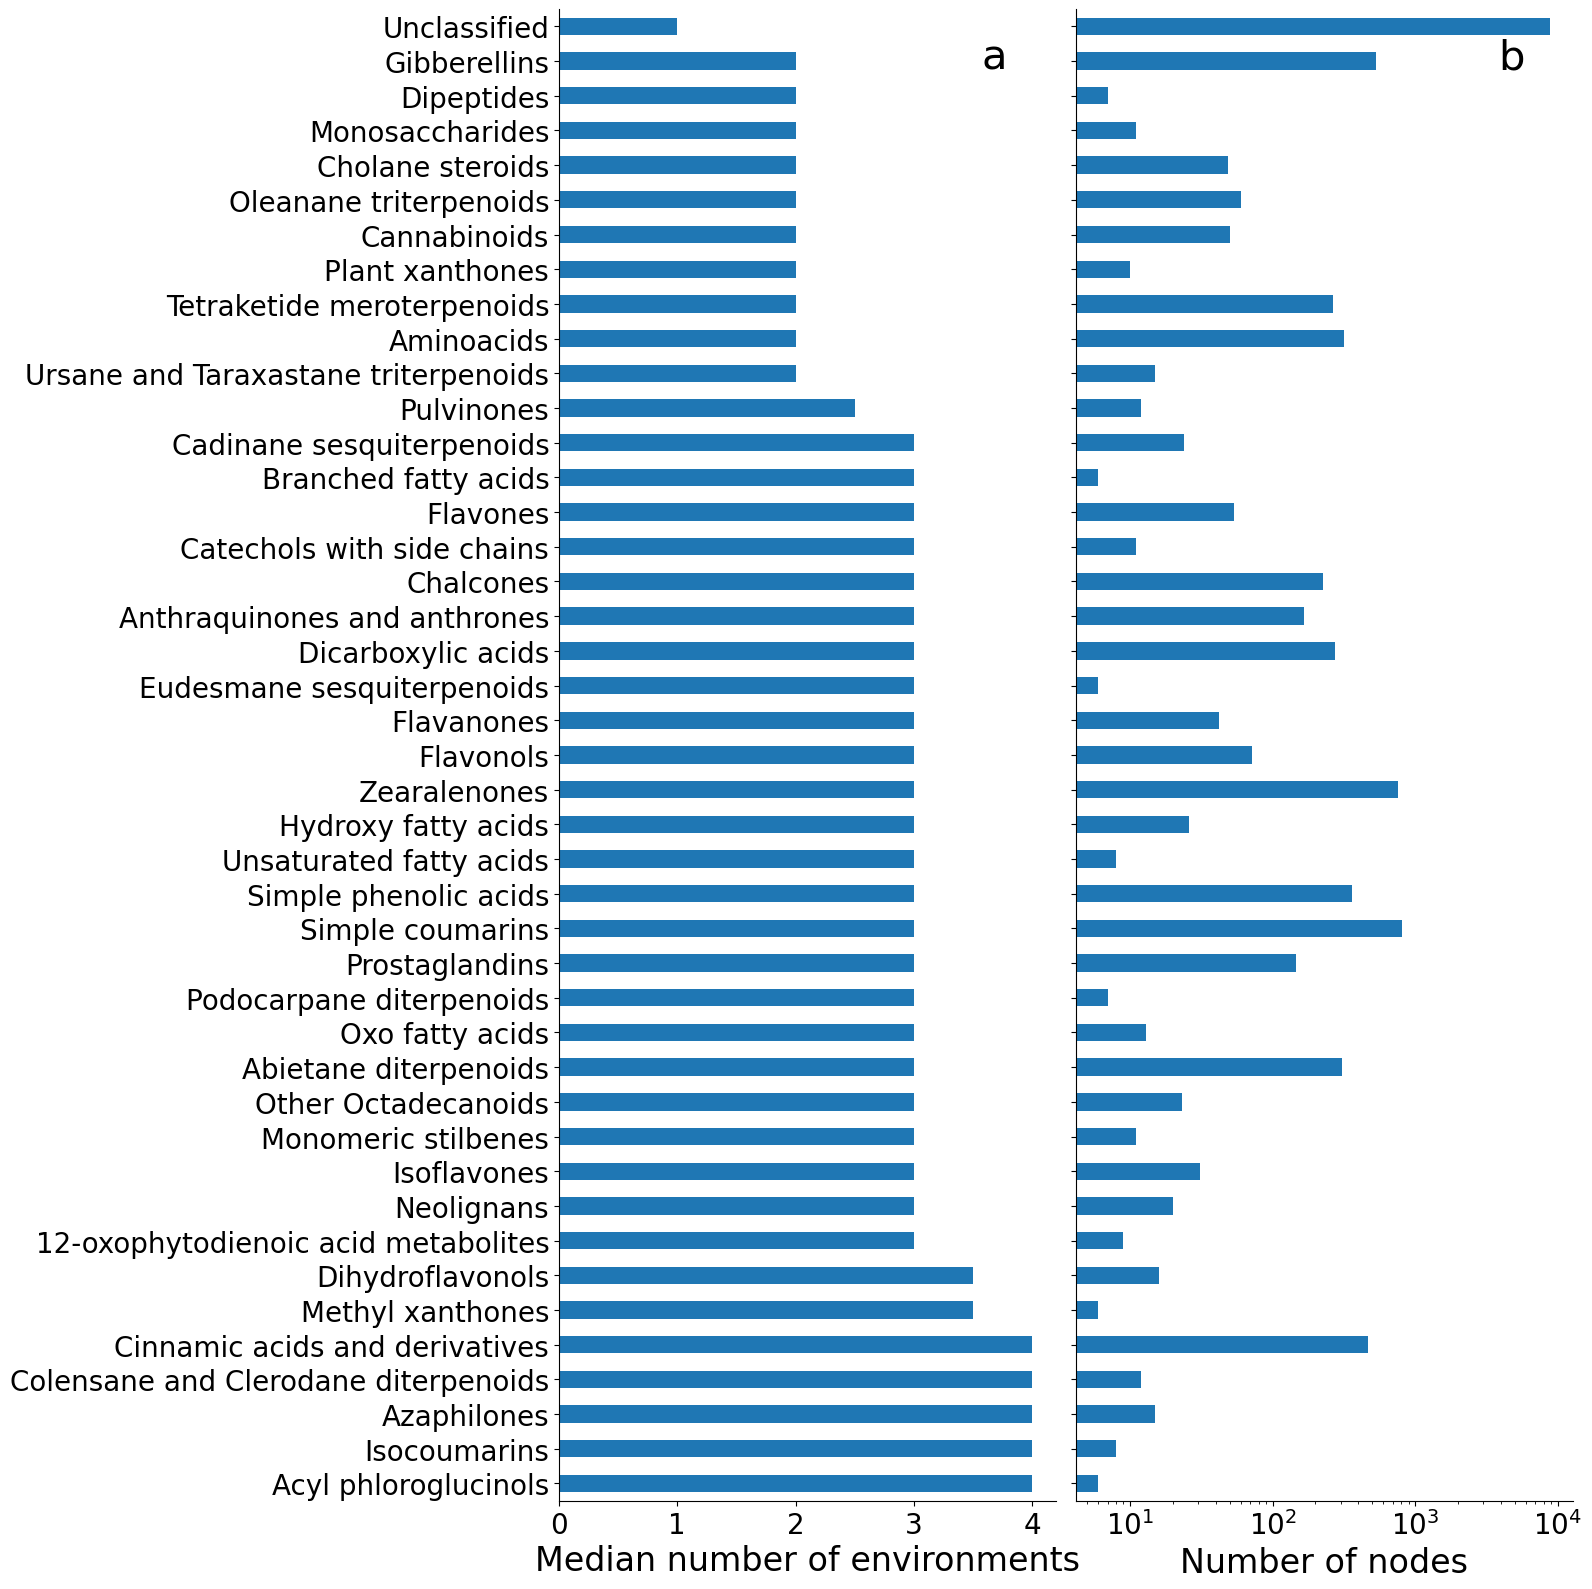

In [47]:
# num_envs['specificity'] = num_envs['num_envs']==1
g = num_envs.reset_index().groupby('class_results_propagated')['num_envs'].agg(['median','count'])
g = g[g['count']>5]
g.sort_values('median',ascending=False,inplace=True)
g.rename(columns={'median':'median_num_env','count':'number of nodes'},inplace=True)
g.to_csv('../../data/node_specificity_withcompoundclass.csv')

# make two bar plots 
# 1. the number of environments each node is found in and 
# 2. the number of nodes in each class
# have the compound class between the two plots
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,16),sharey=True)
g['number of nodes'].plot(kind='barh',ax=ax[1])
g['median_num_env'].plot(kind='barh',ax=ax[0])
# offset the second bar plot by bar width
# put the y axis on the right
ax[1].set_xlabel('Number of nodes',fontsize=24)
ax[0].set_xlabel('Median number of environments',fontsize=24)
ax[0].set_ylabel('')

# add a,b,c labels to each subplot, compensa5te for the shared y axis
import string
for i,axi in enumerate(ax):
    axi.text(0.85, 0.96, string.ascii_lowercase[i], transform=axi.transAxes, size=30)#, weight='bold')

# remove the plot frame
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# tick label font size
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=20)

ax[1].set_xscale('log')

plt.tight_layout()

In [ ]:
num_envs['specificity'] = num_envs['num_envs']==1
g = num_envs.reset_index().groupby('class_results_propagated')['specificity'].agg(['mean','count'])
g = g[g['count']>10]
g.sort_values('mean',ascending=False,inplace=True)
g.rename(columns={'mean':'specificity','count':'number of nodes'},inplace=True)
g.to_csv('../../data/node_specificity_withcompoundclass.csv')

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,8),sharey=True)
g['specificity'].plot(kind='barh',ax=ax[0])
# offset the second bar plot by bar width
# ax2.spines['top'].set_position(('outward', 0))
# ax2.spines['top'].set_color('red')
# ax2.spines['top'].set_linewidth(2)
# ax2.set_xlim(ax.get_xlim())
# ax2.set_xscale('log')

# Get the current bar positions and widths
# positions = ax.get_yticks()
# width = ax.patches[0].get_width()

# ax2.set_ylabel('')
ax[0].set_xlabel('Fraction of nodes specific to an environment',fontsize=16)
ax[0].set_ylabel('Propagated compound class',fontsize=16)
ax[0].set_ylim(-1,len(g))
ax[0].set_xlim(0,0.5)
# Add the width to the positions for the second bar chart
g['number of nodes'].plot(kind='barh',ax=ax[1])
ax[1].set_xlabel('Number of nodes',fontsize=16)
ax[1].set_xscale('log')

# increase fontsize of tick labels
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=16)
# add a legend for both axes locate it in the upper right corner
# fig.legend(['Specificity','Number of Nodes'],bbox_to_anchor=(0.95,0.85), loc="upper right")
plt.tight_layout()
plt.show()
fig.savefig('../../figures/node_specificity_withcompoundclass.pdf',bbox_inches='tight')


In [ ]:
cols = ['Ursane and Taraxastane triterpenoids',
 'Oleanane triterpenoids',
 'Tetraketide meroterpenoids',
 'Anthraquinones and anthrones',
 'Prostaglandins',
 'Cholane steroids',
 'Plant xanthones',
 'Abietane diterpenoids']
print(g.loc[cols]['number of nodes'].sum())
cols = [ 'Simple coumarins',
 'Other Octadecanoids',
 'Dicarboxylic acids',
 'Cinnamic acids and derivatives',
 'Simple phenolic acids',
 'Flavonols']
print(g.loc[cols]['number of nodes'].sum())

g.tail(10).index.to_list()

In [ ]:
sum(num_envs['num_envs']<3),sum(num_envs['num_envs']>=3)

In [ ]:
fig,ax = plt.subplots()
y = num_envs['num_envs'].value_counts()
y = y.sort_index()
y.plot(kind='bar',ax=ax)
ax.set_xlabel('Number of Environments')
ax.set_ylabel('Number of Nodes')

In [19]:
unique_nodes = ms2_data.groupby('environment')['node_id'].value_counts().reset_index(name='count')
unique_nodes = unique_nodes[unique_nodes['count']>0]
unique_nodes = unique_nodes.groupby('environment')['node_id'].unique()
unique_nodes = unique_nodes.to_dict()
# use the set cover algorithm to find the top species that cover the most nodes
# Create a dictionary where the keys are species and the values are sets of nodes that the species cover
species_nodes = {species: set(nodes) for species, nodes in unique_nodes.items()}



In [ ]:
def set_cover(coverage_dict):
    coverage_dict = coverage_dict.copy()
    # Create a list of all unique nodes
    all_nodes = set()
    for nodes in coverage_dict.values():
        all_nodes.update(nodes)
    
    # Initialize an empty list to store selected species
    selected_species = []
    
    # While there are still uncovered nodes
    while all_nodes:
        # Find the species that covers the maximum number of uncovered nodes
        best_species = None
        best_covered = set()
        
        for species, nodes in coverage_dict.items():
            # Calculate the number of uncovered nodes covered by this species
            covered = nodes.intersection(all_nodes)
            
            # If this species covers more nodes than the current best, update
            if len(covered) > len(best_covered):
                best_species = species
                best_covered = covered
        
        # Add the best species to the selected species list
        selected_species.append(best_species)
        
        # Remove the covered nodes from the set of all nodes
        all_nodes.difference_update(best_covered)
        
        # Remove the best species from the dictionary to prevent it from being chosen again
        del coverage_dict[best_species]
    
    return selected_species

selected_species = set_cover(species_nodes)
print("Selected species:", selected_species[:5])


In [ ]:
node_data = at.graph_to_df()
num_nodes_total = node_data.shape[0]

In [ ]:
# bar chart the compound classes
y1 = node_data['class_results_propagated'].value_counts()#.apply(np.log10)
y2 = node_data['class_results'].value_counts()#.apply(np.log10)
y = pd.concat([y1,y2],axis=1)
y = y[y['class_results']>5]
fig,ax = plt.subplots(figsize=(7,12))
y.plot(kind='barh',ax=ax)
ax.set_xscale('log')
ax.set_xlabel('Number of Nodes')
plt.show()

In [ ]:
# for species in selected_species[:10]:
#     nodes = species_nodes[species]
#     print(f"Species {species} covers {len(nodes)} nodes")
num_nodes_total = node_data.shape[0]
n = len(selected_species)
# now show their combined coverage
combined_nodes = set()
combined_count = []
individual_count = []
for species in selected_species[:n]:
    combined_nodes.update(species_nodes[species])
    combined_count.append(len(combined_nodes))
    individual_count.append(len(species_nodes[species]))

fig,ax = plt.subplots(figsize=(10,4))
# make a second y-axis using twinx
# ax2 = ax.twinx()
ax.bar(range(n),individual_count,color='orange',alpha=0.5)
ax.plot(range(n),combined_count,'.-',markersize=18)
ax.set_xlabel('Cumulative Addition of Environments')
ax.set_ylabel('Number of Cumulative Nodes\nAcross Environments')
ax.set_ylabel('Nodes present in an\nIndividual Environment')
# ax.set_title('Set Cover Algorithm for Selection')
ax.set_xticks(range(n))
ax.set_xticklabels(selected_species[:n],rotation=45,ha='right')
ax.grid(True)
# ax.set_ylim(13000,17000)
ax.axhline(num_nodes_total,color='k',linestyle='--')
ax.legend(['Cumulative','EMN-Total','Individual'],loc='upper left',bbox_to_anchor=(0.01,1.20))
# ax.legend(['Individual'],loc='lower right',bbox_to_anchor=(0.4,1.05))
# ax2.set_ylim(0,17000)
plt.show()

In [ ]:
# how many nodes are covered by each environment
node_counts = ms2_data.groupby('environment')['node_id'].nunique()
node_counts = node_counts.sort_values(ascending=False)


n = len(node_counts)
# now show their combined coverage
combined_nodes = set()
combined_count = []
individual_count = []
for species in node_counts.index:
    combined_nodes.update(species_nodes[species])
    combined_count.append(len(combined_nodes))
    individual_count.append(len(species_nodes[species]))

fig,ax = plt.subplots(figsize=(10,4))
ax.plot(range(len(node_counts)),combined_count,'.-')
ax.bar(range(len(node_counts)),individual_count)
ax.set_xlabel('Cumulative Addition of Environments')
ax.set_ylabel('Number of ENVnet-Nodes Detected')
ax.set_xticks(range(len(node_counts)))
ax.set_xticklabels(node_counts.index,rotation=45,ha='right')
ax.legend(['Cumulative','Individual'])
ax.grid(True)
plt.show()


# # make a cumulative histogram of the node counts 
# ax.bar(range(len(node_counts)),node_counts)
# ax.set_xlabel('Environment')
# ax.set_ylabel('Number of ENVnet-Nodes Detected')
# ax.set_title('ENVnet-Nodes Detected in Different Environments')
# ax.set_xticks(range(len(node_counts)))
# ax.set_xticklabels(node_counts.index,rotation=45,ha='right')
# ax.grid(True)

In [ ]:

# Now you can create an UpSet plot
# upset = UpSet(df, subset_size='count')
# upset.plot(max_degree=1)


In [ ]:
g = pd.merge(ms2_data,file_df,left_on='lcmsrun_observed',right_on='parquet',how='inner')
g.groupby('node_id').apply(lambda x: x['name'].unique()).value_counts()

In [ ]:
# best_hits = best_hits[best_hits['peak_area']>1e4]
# best_hits[pd.notna(best_hits['ms2_score'])]

In [ ]:
def make_output_df(node_data,best_hits,filename='output.csv'):
    output = node_data.copy()
    output.set_index('node_id',inplace=True)
    output = output.join(best_hits.set_index('node_id'),rsuffix='_best_hit',how='left')
    output.to_csv(filename)
    return output
output_df = make_output_df(node_data,best_hits,filename='../../data/BestHits_PlantData.csv')
ms1_data.to_csv('../../data/Plants_ms1_data.csv')
ms2_data.to_csv('../../data/Plants_ms2_data.csv')

In [ ]:
sum(output_df['ms2_score']>0.75)

In [ ]:
ms2_data['plant'] = ms2_data['lcmsrun_observed'].apply(lambda x: os.path.basename(x).split('_')[12])

In [ ]:
d_sample = ms2_data.pivot_table(index='node_id',columns=['plant'],values='score',aggfunc='max',fill_value=0)
d_sample = d_sample>0.6
d_sample.sum().sort_values(ascending=False).head(20)

In [ ]:
files = ms1_data['lcmsrun_observed'].unique()
ms1_data['plant'] = ms1_data['lcmsrun_observed'].apply(lambda x: os.path.basename(x).split('_')[12])


In [ ]:
d_sample = ms1_data.pivot_table(index='node_id',columns=['plant'],values='peak_area',aggfunc='mean',fill_value=300)
d_sample.to_csv('PeakArea_ExudateData-groupedbyplant.csv') 
d_sample = d_sample>1e7


In [ ]:
d_sample.sum().sort_values(ascending=False).head(20)

In [ ]:
d_sample = ms1_data.pivot_table(index='node_id',columns=['lcmsrun_observed'],values='peak_area',aggfunc='mean',fill_value=300)
d_sample.to_csv('PeakArea_ExudateData.csv') 


In [ ]:
import pandas as pd
plant = pd.read_csv('PeakArea_PlantData.csv')